# Face_mask_detection


In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [2]:
img_dir = "dataset/Medical mask/Medical mask/Medical Mask/images"
train_full = pd.read_csv("dataset/train.csv")
submission = pd.read_csv("dataset/submission.csv")

In [3]:
train_full.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [4]:
options = ['face_with_mask','face_no_mask']
train = train_full[train_full['classname'].isin(options)].sort_values('name')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


train['target'] = le.fit_transform(train.classname)
print("Number of unique images in train set: ", train.name.nunique())
train.head()

Number of unique images in train set:  3390


,name,x1,x2,y1,y2,classname,target
13381,1801.jpg,451,186,895,697,face_no_mask,0
3463,1802.jpg,110,71,273,272,face_with_mask,1
14835,1803.jpg,126,75,303,333,face_with_mask,1
5867,1804.jpg,112,113,262,307,face_with_mask,1
6194,1805.jpg,728,180,853,336,face_with_mask,1


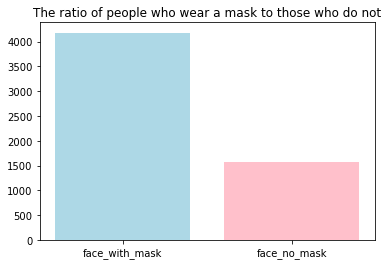

In [5]:
plt.bar(['face_with_mask','face_no_mask'], train.classname.value_counts(), color = ['lightblue','pink']);
plt.title('The ratio of people who wear a mask to those who do not');

In [6]:
print("Number of unique images in submission set: ", submission.name.nunique())
submission.head()

Number of unique images in submission set:  1698


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [7]:
train_images = train.name.unique().tolist()

test_images = submission.name.unique().tolist()

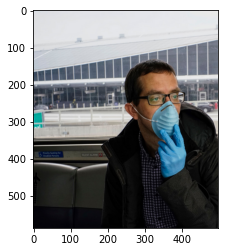

In [8]:

i = np.random.choice(np.arange(1801, len(train_images)))
img = plt.imread(os.path.join(img_dir,train_images[i]))

plt.imshow(img)

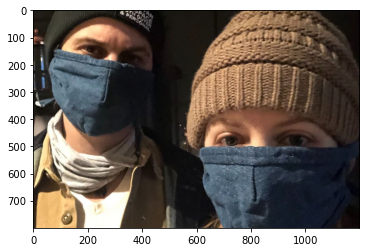

In [9]:

i = np.random.choice(len(test_images))
img = plt.imread(os.path.join(img_dir,test_images[i]))

plt.imshow(img)

In [10]:

bounding_box=[]
for i in range(len(train)):
    lst = []
    
    for box in train.iloc[i][["x1",'x2','y1','y2']]:
        lst.append(box)
    bounding_box.append(lst)
    

train["bounding_box"] = bounding_box  

def get_boxes(filename):
    boxes = []

    for box in train[train["name"] == filename]["bounding_box"]:
        boxes.append(box)
    return boxes

[[258, 5, 331, 105], [130, 101, 212, 186], [370, 117, 416, 179]]


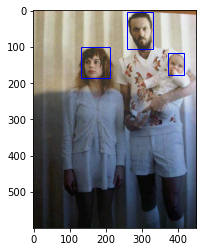

In [11]:

def draw_facebox(image, boxes):

    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        
        x, y, width, height = box[0], box[1], box[2], box[3],

        rect = plt.Rectangle((x, y), width-x, height-y, 
                             fill=False, color='b', linewidth=1)
        ax.add_patch(rect)
        
    plt.show()
    

i = np.random.choice(np.arange(1801, len(train_images)))

image = plt.imread(os.path.join(img_dir,train_images[i]))

boxes = get_boxes(train_images[i])
print(boxes)

draw_facebox(image, boxes)

In [12]:
img_size=128
data=[]
for i in range(len(train)):
    x,y,width,height = train.iloc[i]['bounding_box']
    image = train.iloc[i]['name']
    img_array = cv2.imread(os.path.join(img_dir,image), 1)
    
    img_cropped = img_array[y:height,x:width] 
    img = cv2.resize(img_cropped,(img_size,img_size))
    data.append([img,train.iloc[i]['target']])     

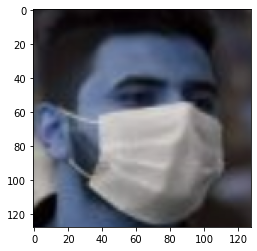

In [13]:

i = np.random.choice(range(len(data)))
plt.imshow(data[i][0]);

In [14]:
X=[]
Y=[]
for features, labels in data:
    X.append(features)
    Y.append(labels)
X = np.array(X)/255 
print('Shape of X:', X.shape)
Y = np.array(Y)
print('Shape of Y:', Y.shape)

Shape of X: (5749, 128, 128, 3)
Shape of Y: (5749,)


In [15]:

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, activation="relu", padding='same', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X, Y,train_size=0.8,random_state=0)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='binary_crossentropy', metrics=['accuracy']) 

history = model.fit(X_train,y_train,batch_size=32,
                 epochs=10,
                 validation_data=(X_val, y_val))

Epoch 1/10
144/144 [==============================] - 51s 349ms/step - loss: 0.5291 - accuracy: 0.7434 - val_loss: 0.2839 - val_accuracy: 0.8904
Epoch 2/10
144/144 [==============================] - 50s 350ms/step - loss: 0.2747 - accuracy: 0.8921 - val_loss: 0.2617 - val_accuracy: 0.9061
Epoch 3/10
144/144 [==============================] - 49s 338ms/step - loss: 0.2544 - accuracy: 0.8942 - val_loss: 0.2842 - val_accuracy: 0.8748
Epoch 4/10
144/144 [==============================] - 49s 342ms/step - loss: 0.2605 - accuracy: 0.8914 - val_loss: 0.2398 - val_accuracy: 0.9096
Epoch 5/10
144/144 [==============================] - 49s 337ms/step - loss: 0.2344 - accuracy: 0.8989 - val_loss: 0.2174 - val_accuracy: 0.9200
Epoch 6/10
144/144 [==============================] - 49s 340ms/step - loss: 0.2334 - accuracy: 0.9032 - val_loss: 0.2037 - val_accuracy: 0.9226
Epoch 7/10
144/144 [==============================] - 48s 335ms/step - loss: 0.2158 - accuracy: 0.9127 - val_loss: 0.2130 - val_ac

Text(0.5, 0, 'Epoch')

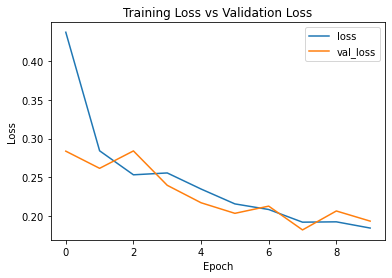

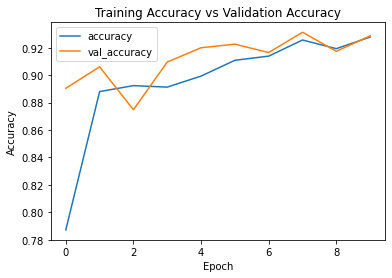

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [19]:
pip install mtcnn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: keras>=2.0.0 in c:\users\debjyoti\anaconda3\lib\site-packages (from mtcnn) (2.4.3)



In [20]:
def draw_facebox(image, boxes):

    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        x, y, width, height = box[0], box[1], box[2], box[3],
        rect = plt.Rectangle((x, y), width, height, 
                             fill=False, color='r', linewidth=1)

        ax.add_patch(rect)

    plt.show()

[]


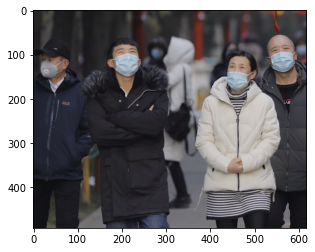

In [21]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()

i = np.random.choice(len(test_images))

image = plt.imread(os.path.join(img_dir, train_images[i]))

faces = detector.detect_faces(image)
boxes = [face['box'] for face in faces if face['confidence']>0.99]
print(boxes)

draw_facebox(image, boxes)

In [22]:

names = []
bboxes = []
for img_name in test_images:

    image = plt.imread(os.path.join(img_dir, img_name))
    faces = detector.detect_faces(image)
    for face in faces: 
        if face['confidence']>0.99:
            names.append(img_name)
            bboxes.append(face['box'])

df = pd.DataFrame({'name' : names, 'bounding_box' : bboxes})
df.head()

,name,bounding_box
0,1800.jpg,"[956, 460, 246, 326]"
1,1796.jpg,"[933, 207, 232, 298]"
2,1796.jpg,"[728, 177, 84, 107]"
3,1796.jpg,"[469, 223, 186, 229]"
4,1795.jpg,"[688, 4, 40, 47]"


In [23]:
data=[]
for i in range(len(df)):

    x,y,width,height = [0 if value < 0 else value for value in df.iloc[i]['bounding_box']]
    image = df.iloc[i]['name']
    img_array = cv2.imread(os.path.join(img_dir,image), 1)
    img_cropped = img_array[y:y+height,x:x+width]  
    img = cv2.resize(img_cropped,(img_size,img_size))
    data.append(img)

In [24]:
X = np.array(data)/255
predict = model.predict(X)
df['classname'] = ['face_with_mask' if i > 0.8 else 'face_with_no_mask' for i in predict]
df

,name,bounding_box,classname
0,1800.jpg,"[956, 460, 246, 326]",face_with_no_mask
1,1796.jpg,"[933, 207, 232, 298]",face_with_mask
2,1796.jpg,"[728, 177, 84, 107]",face_with_no_mask
3,1796.jpg,"[469, 223, 186, 229]",face_with_mask
4,1795.jpg,"[688, 4, 40, 47]",face_with_no_mask
...,...,...,...
1960,0011.jpg,"[204, 72, 65, 85]",face_with_no_mask
1961,0011.jpg,"[406, 106, 70, 97]",face_with_no_mask
1962,0006.jpg,"[441, 668, 57, 70]",face_with_no_mask
1963,0004.jpg,"[630, 176, 212, 266]",face_with_mask


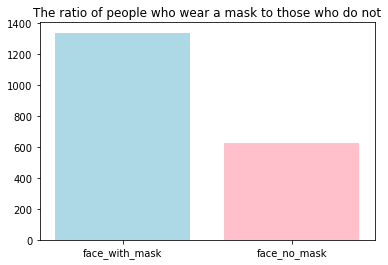

In [25]:
plt.bar(['face_with_mask','face_no_mask'], df.classname.value_counts(), color = ['lightblue','pink']);
plt.title('The ratio of people who wear a mask to those who do not');

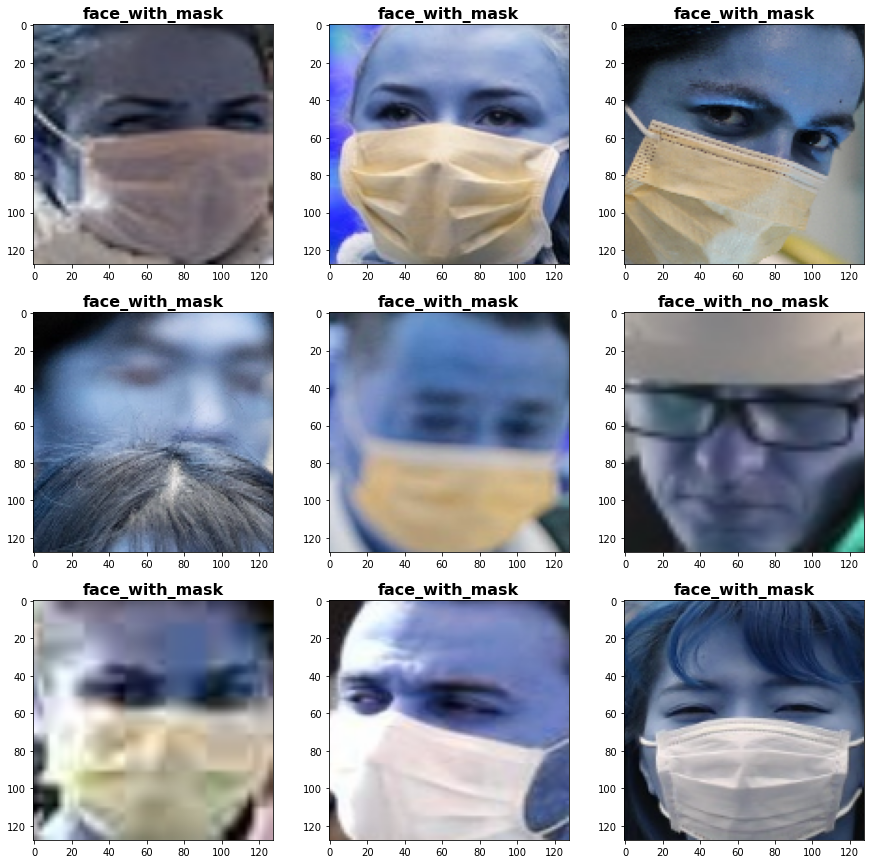

In [26]:

indexes = np.random.choice(df.index, 9)

fig, axes = plt.subplots(nrows=3, ncols=3) 
i = 0
fig.set_figheight(15)
fig.set_figwidth(15)
for row in axes:
    for col in row:
        col.imshow(data[indexes[i]])
        col.set_title(df.iloc[indexes[i]]['classname'],fontsize=16,fontweight='bold' )
        i+=1
plt.show()

In [27]:

df.to_csv('submission_1.csv')